# Dataset
The dataset consists of MRI images of 100 subjects, as published in [this paper](https://doi.org/10.1109/TMI.2018.2837502).

There is a folder for each patient and each folder contains six files:


*   **patientXYZ_4d.nii.gz** The 4D cardiac cine MR study for the patient. This study contains 3D images of the heart at different timepoints (so-called frames). The number of frames per patient differs, but is in the order of 15-30.
*   **Info.cfg** A file with information about the patient. This file contains 
  * **ED**: The end-diastolic frame. Frame numbers start at 1 and not at 0. So ED: 1 means that the first frame in the 4D sequence is at end-diastole.
  * **ES**: The end-systolic frame.
  * **Group**: Patient disease classification, can be ignored.
  * **Height**: Patient height, can be ignored.
  * **NbFrame**: Number of frames in the corresponding 4D sequence.
  * **Weight**: Patient weight, can be ignored.
* **patientXYZ_frame^^.nii.gz** There are two such files containing 3D cardiac volumes, one for end-diastole and one for end-systole. These are two frames taken out of the 4D sequence for your convenience.
* **patientXYZ_frame^^_gt.nii.gz** Manual reference segmentations corresponding to the 3D cardiac volumes, one for end-diastole and one for end-systole. This contains annotations for the right ventricle (1), left ventricular myocardium (2) and left ventricular cavity (3)


# Loading and processing data
First we install [SimpleITK](http://www.simpleitk.org/), a Python library that allows you to use many of the best things in [ITK](https://itk.org/). For one, it's very useful to read and write medical images in many formats (DICOM, nifti, metaimage, etc.). Run the block below to install SimpleITK in this runtime.

In [1]:
!pip install SimpleITK

# Loading data
We can use SimpleITK to load the 4D nifti images. Note that the extension is **.nii.gz**, which means that they are compressed files. SimpleITK will automatically unzip the compressed files and provide a SimpleITK Image object. From this object, we can obtain some useful information.

In [2]:
import SimpleITK as sitk # First we import SimpleITK
import numpy as np

# Directory of ACDC dataset! 
datapath = 'Data\patient077'

im = sitk.ReadImage(r'{}\patient077_4d.nii.gz'.format(datapath))

# Print the size of the image
print('Size of the image is {}'.format(im.GetSize()))

# Print the spacing of the image
spacing = im.GetSpacing()
print('Spacing of the image is {}'.format(spacing))

Size of the image is (214, 256, 8, 25)
Spacing of the image is (1.40625, 1.40625, 10.0, 1.0)


Note how the order of the image size is (width {x}, height {y}, depth {z}, time {t}). Also note how the spacing in the z-direction is much larger than in the x- and y-direction. These voxels are highly anisotropic.

In addition to the GetSpacing() function, there is a SetSpacing() function, which may be useful for writing results. Similarly, there is a WriteImage() function.

SimpleITK has a function to get a Numpy array from this image so that we can actually do something with the data: GetArrayFromImage(). The other way around uses GetImageFromArray().

In [3]:
im_np = sitk.GetArrayFromImage(im)
print('Size of the image in Numpy is {}'.format(im_np.shape))

Size of the image in Numpy is (25, 8, 256, 214)


**Be careful here, the order of the axes is reversed in Numpy.** 

Let's import matplotlib to show some of the images.

In [4]:
import matplotlib.pyplot as plt # matplotlib is a nice library for plotting
%matplotlib inline

Now let's plot a grid of one 2D slice over all frames. 


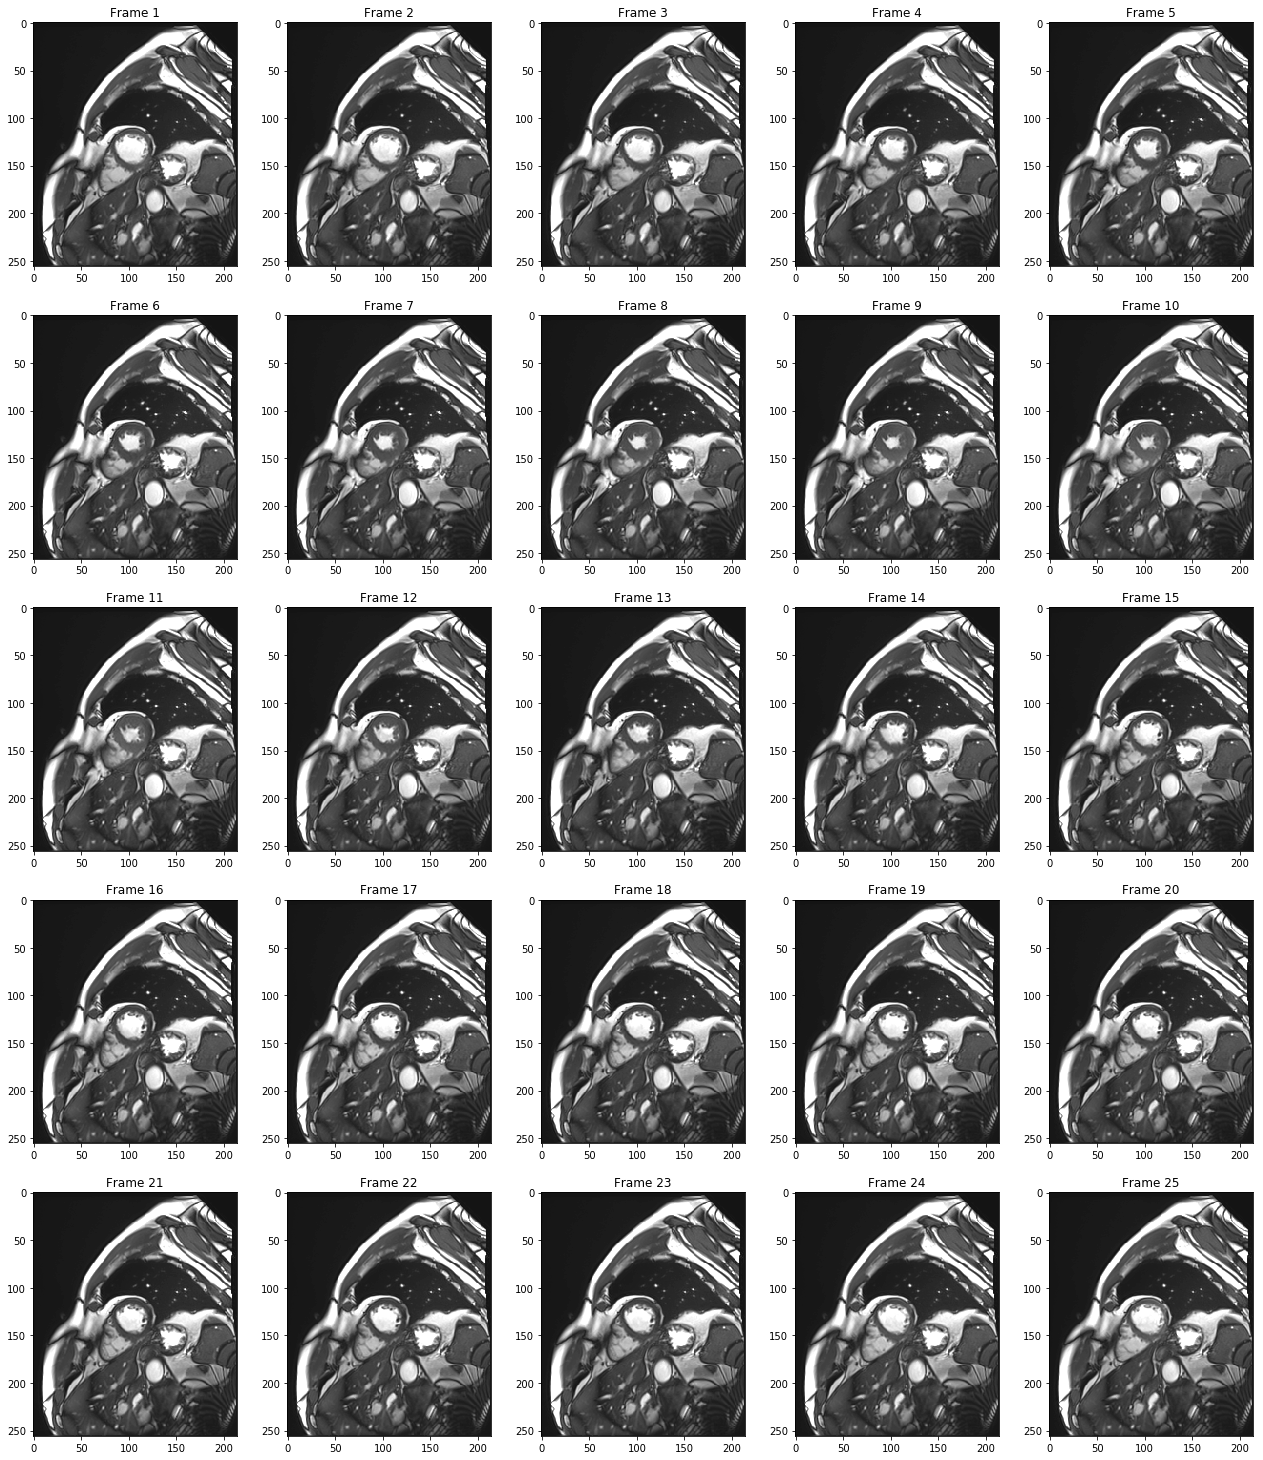

In [5]:
plt.rcParams["figure.figsize"] = (22, 26) # (w, h)
z_index = 4
n_rows = np.ceil(np.sqrt(im_np.shape[0]))
n_cols = np.ceil(np.sqrt(im_np.shape[0]))

for t in range(im_np.shape[0]): 
  plt.subplot(n_rows, n_cols, 1 + t)
  plt.imshow(im_np[t, z_index, :, :], clim=(0, 150), cmap='gray')
  plt.title('Frame {}'.format(t + 1))
plt.show()

Load reference segmentations and show them along with the image at end-diastole.



In [6]:
im_ED = sitk.ReadImage(r'{}\patient077_frame01.nii.gz'.format(datapath))
im_ED_np = sitk.GetArrayFromImage(im_ED)
gt_ED = sitk.ReadImage(r'{}\patient077_frame01_gt.nii.gz'.format(datapath))
gt_ED_np = sitk.GetArrayFromImage(gt_ED)

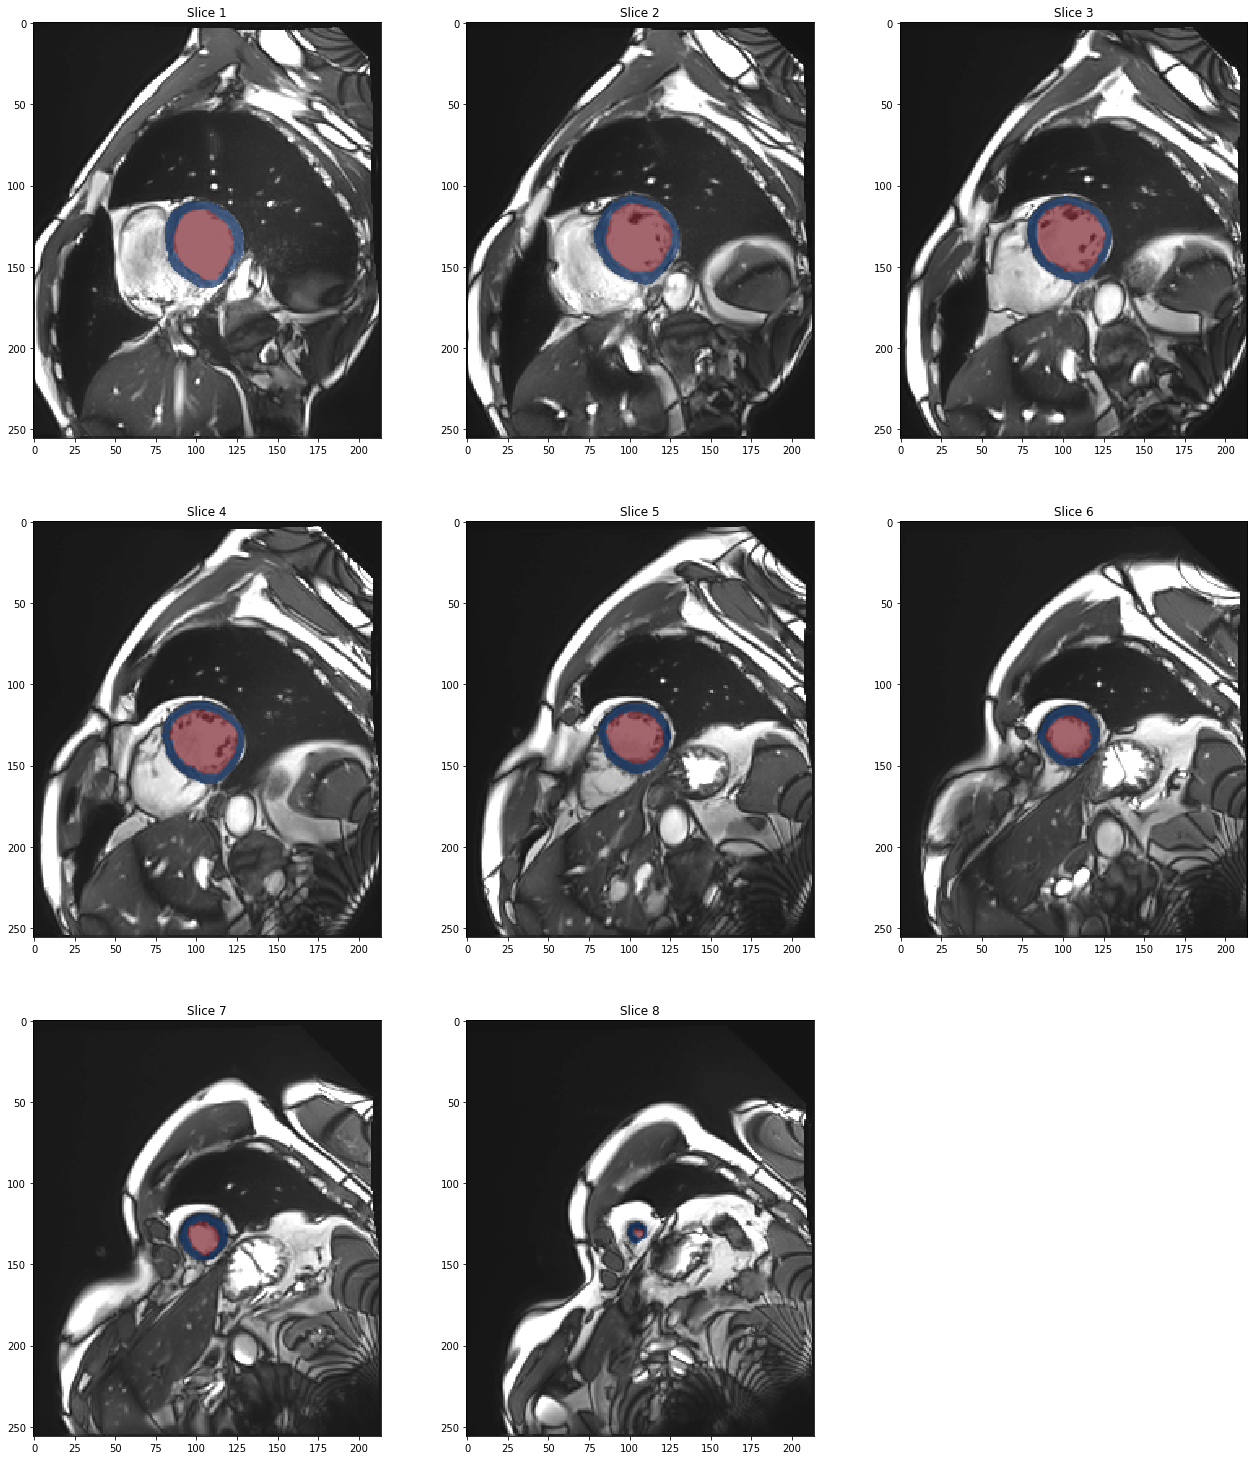

In [7]:
n_rows = np.ceil(np.sqrt(im_ED_np.shape[0]))
n_cols = np.ceil(np.sqrt(im_ED_np.shape[0]))

for z in range(im_ED_np.shape[0]): 
  plt.subplot(n_rows, n_cols, 1 + z)
  plt.imshow(im_ED_np[z, :, :], clim=(0, 150), cmap='gray')
  plt.imshow(np.ma.masked_where(gt_ED_np[z, :, :]!=2, gt_ED_np[z, :, :]==2), alpha=0.6, cmap='Blues', clim=(0, 1))  
  plt.imshow(np.ma.masked_where(gt_ED_np[z, :, :]!=3, gt_ED_np[z, :, :]==3), alpha=0.6, cmap='Reds', clim=(0, 1))
  plt.title('Slice {}'.format(z + 1))
plt.show()

And the same for end-systole.

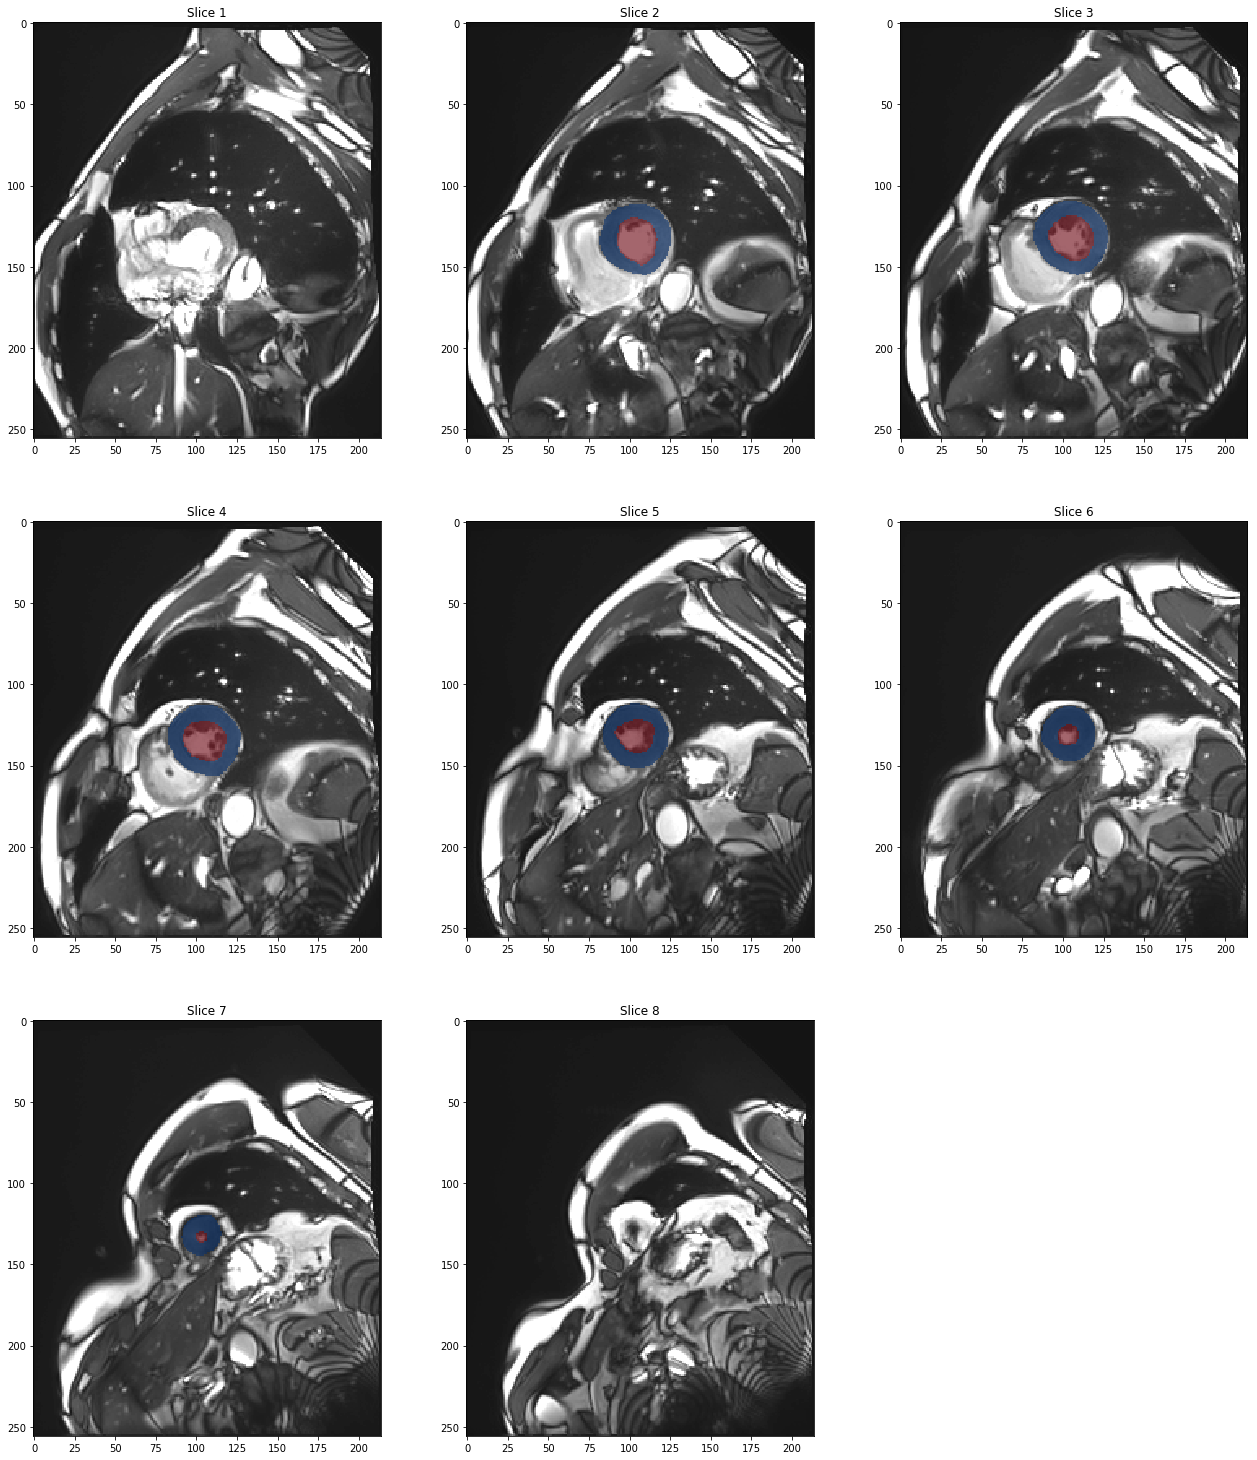

In [8]:
im_ES = sitk.ReadImage(r'{}\patient077_frame09.nii.gz'.format(datapath))
im_ES_np = sitk.GetArrayFromImage(im_ES)
gt_ES = sitk.ReadImage(r'{}\patient077_frame09_gt.nii.gz'.format(datapath))
gt_ES_np = sitk.GetArrayFromImage(gt_ES)

n_rows = np.ceil(np.sqrt(im_ES_np.shape[0]))
n_cols = np.ceil(np.sqrt(im_ES_np.shape[0]))

for z in range(im_ES_np.shape[0]): 
  plt.subplot(n_rows, n_cols, 1 + z)
  plt.imshow(im_ES_np[z, :, :], clim=(0, 150), cmap='gray')
  plt.imshow(np.ma.masked_where(gt_ES_np[z, :, :]!=2, gt_ES_np[z, :, :]==2), alpha=0.6, cmap='Blues', clim=(0, 1))  
  plt.imshow(np.ma.masked_where(gt_ES_np[z, :, :]!=3, gt_ES_np[z, :, :]==3), alpha=0.6, cmap='Reds', clim=(0, 1))
  plt.title('Slice {}'.format(z + 1))
plt.show()

# Ejection fraction

Finally, we can compute the ejection fraction by using the segmentations at end-diastole and end-systole.

In [9]:
voxelvolume = spacing[0]*spacing[1]*spacing[2]
ED_volume = np.sum(gt_ED_np==3)*voxelvolume
ES_volume = np.sum(gt_ES_np==3)*voxelvolume

strokevolume = ED_volume - ES_volume
LV_EF = (strokevolume/ED_volume)*100

print('LV stroke volume is {:.2f} ml and ejection fraction is {:.2f}%'.format(strokevolume*0.001, LV_EF))

LV stroke volume is 90.67 ml and ejection fraction is 67.19%
